In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

plt.rcParams.update({
    "font.size": 14
}) 

In [60]:
def calculate_cv(theta_2, theta_3):
    sigma_h_sq = theta_3 ** 2 / (1 - theta_2 ** 2)
    return np.exp(sigma_h_sq) - 1

In [77]:
def plot_cv_theta_two(df_qml, df_smm, title, x_bounds=None, y_bounds=None):
    _, ax = plt.subplots(figsize=(7, 7))
    sns.scatterplot(data=df_qml, x="cv", y="estimates_2", ax=ax, label="QML");
    sns.scatterplot(data=df_smm, x="cv", y="estimates_2", ax=ax, label="SMM");
    ax.set_xlabel("CV")
    ax.set_ylabel("theta_2")
    ax.set_title(title)
    if x_bounds is not None:
        ax.set_xlim(x_bounds)
    if y_bounds is not None:
        ax.set_ylim(y_bounds)

In [65]:
def plot_qml_vs_smm_estimates(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17, 7))

    for i in range(3):
        qml_col = f"estimates_{i+1}_qml"
        smm_col = f"estimates_{i+1}_smm"
        min_value = min(df[qml_col].min(), df[smm_col].min())
        max_vallue = max(df[qml_col].max(), df[smm_col].max())
        y_eq_x_line = np.linspace(min_value, max_vallue, 1000)
        sns.lineplot(x=y_eq_x_line, y=y_eq_x_line, ax=ax[i], label="y=x", color="red", linestyle="--")
        sns.scatterplot(data=df, x=qml_col, y=smm_col, ax=ax[i]);
    fig.suptitle(title)
    plt.tight_layout()

In [71]:
qml_with_outliers = pd.read_csv("qml_estimates_with_outliers.csv")
smm_with_outliers = pd.read_csv("smm_estimates_with_outliers.csv")

qml_without_outliers = pd.read_csv("qml_estimates_without_outliers.csv")
smm_without_outliers = pd.read_csv("smm_estimates_without_outliers.csv")
dfs = [qml_with_outliers, qml_without_outliers, smm_with_outliers, smm_without_outliers]

for df in dfs:
    df["cv"] = calculate_cv(df.estimates_2, df.estimates_3)


with_outliers = pd.merge(qml_with_outliers, smm_with_outliers, on="ticker", suffixes=("_qml", "_smm"))
without_outliers = pd.merge(qml_without_outliers, smm_without_outliers, on="ticker", suffixes=("_qml", "_smm"))

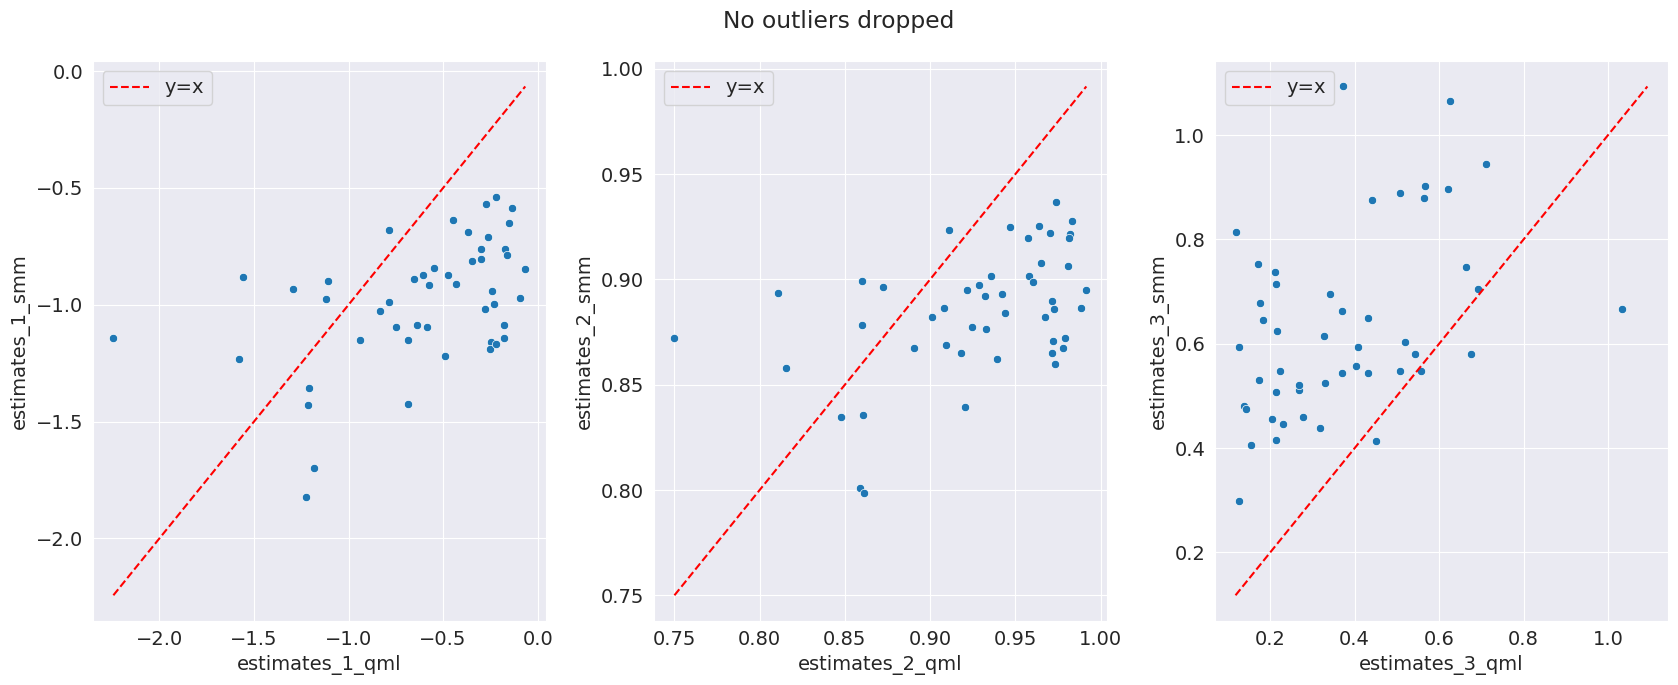

In [72]:
plot_qml_vs_smm_estimates(with_outliers, "No outliers dropped")

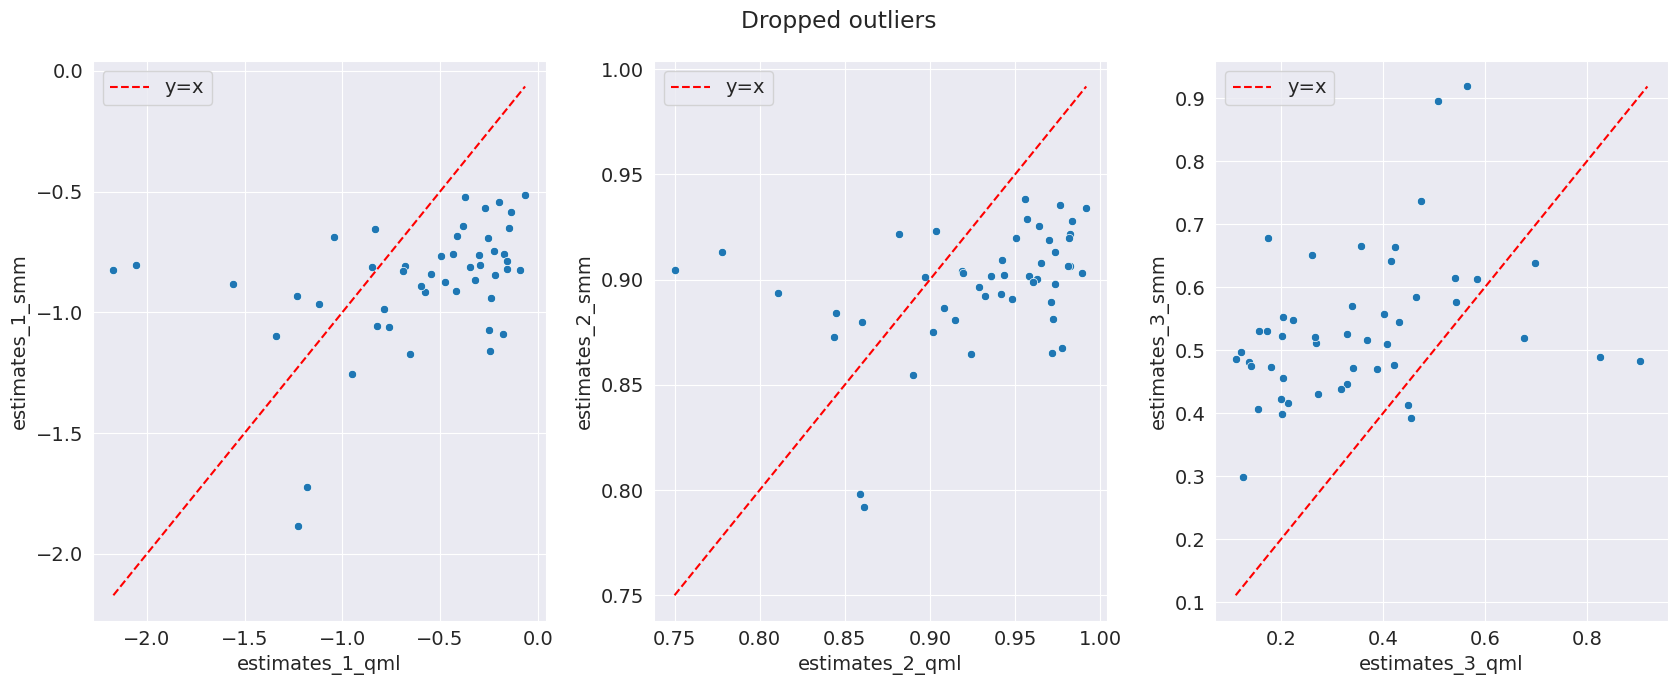

In [73]:
plot_qml_vs_smm_estimates(without_outliers, "Dropped outliers")

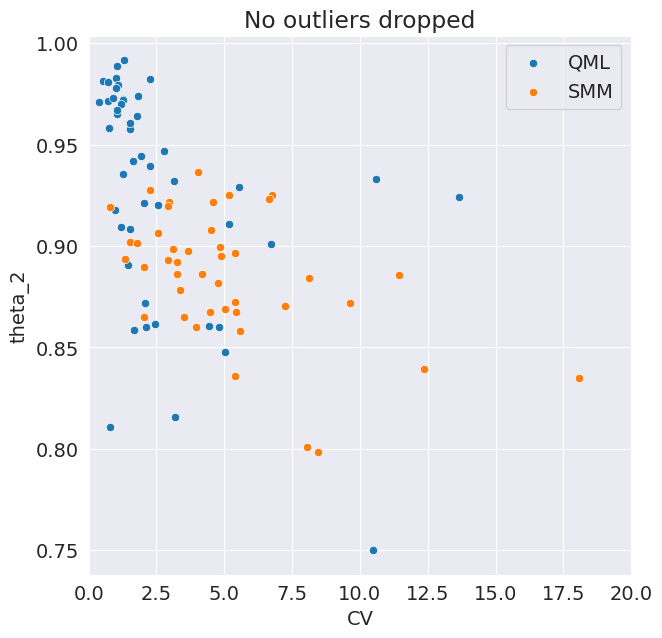

In [78]:
plot_cv_theta_two(qml_with_outliers, smm_with_outliers, "No outliers dropped", x_bounds=(0, 20))

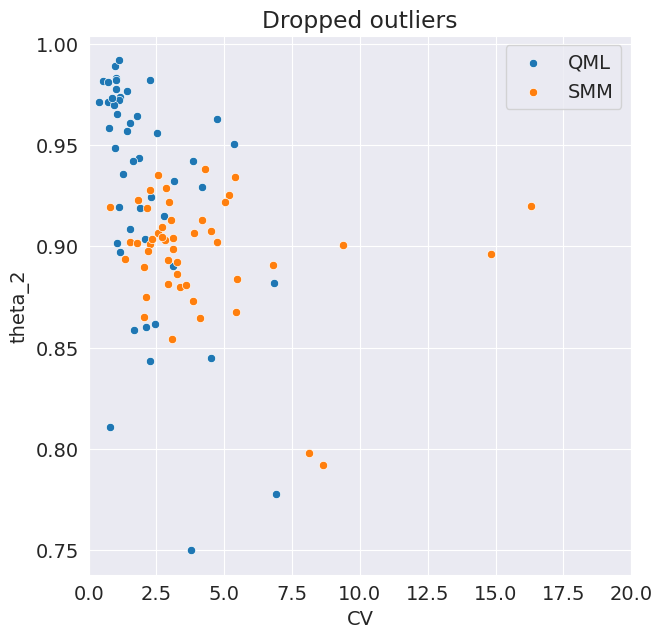

In [79]:
plot_cv_theta_two(qml_without_outliers, smm_without_outliers, "Dropped outliers", x_bounds=(0, 20))